In [1]:
import os
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from label_flip_revised.utils import open_csv, create_dir
from label_flip_revised.simple_nn_model import SimpleModel
from label_flip_revised.torch_utils import evaluate, train_model

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/label_flip_revised


In [3]:
path_cm_poison = glob(os.path.join(PATH_ROOT, 'results', 'synth_nn', '*.csv'))
print(path_cm_poison[:5])

['/home/lukec/workspace/label_flip_revised/results/synth_nn/synth_nn_poison_32.csv', '/home/lukec/workspace/label_flip_revised/results/synth_nn/synth_nn_poison_43.csv', '/home/lukec/workspace/label_flip_revised/results/synth_nn/synth_nn_poison_6.csv', '/home/lukec/workspace/label_flip_revised/results/synth_nn/synth_nn_poison_31.csv', '/home/lukec/workspace/label_flip_revised/results/synth_nn/synth_nn_poison_17.csv']


In [4]:
df_c_measure = pd.DataFrame()
for p in path_cm_poison:
    _df = pd.read_csv(p)
    df_c_measure = pd.concat([df_c_measure, _df])

print(df_c_measure.shape)

(2619, 36)


In [5]:
# Remove NA
print('# of columns before removing NA:', len(df_c_measure.columns) - 1)  # Name does not count
cols_not_na = df_c_measure.columns[df_c_measure.notna().any()].tolist()
df_c_measure = df_c_measure[cols_not_na]
print('# of columns after removing NA:', len(df_c_measure.columns) - 1)  # Name does not count
print(cols_not_na)

# of columns before removing NA: 35
# of columns after removing NA: 28
['Data', 'overlapping.F1.mean', 'overlapping.F1.sd', 'overlapping.F1v.mean', 'overlapping.F2.mean', 'overlapping.F3.mean', 'overlapping.F4.mean', 'neighborhood.N1', 'neighborhood.N2.mean', 'neighborhood.N2.sd', 'neighborhood.N3.mean', 'neighborhood.N3.sd', 'neighborhood.N4.mean', 'neighborhood.N4.sd', 'neighborhood.T1.mean', 'neighborhood.T1.sd', 'neighborhood.LSC', 'linearity.L1.mean', 'linearity.L2.mean', 'linearity.L3.mean', 'dimensionality.T2', 'dimensionality.T3', 'dimensionality.T4', 'balance.C1', 'balance.C2', 'network.Density', 'network.ClsCoef', 'network.Hubs.mean', 'network.Hubs.sd']


In [6]:
# Rename Columns
new_cols = [
    'Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 
    'N2', 'N2 SD', 'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 
    'L1', 'L2', 'L3', 'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 
    'Hubs', 'HubsSD']
new_names_map = {df_c_measure.columns[i]:new_cols[i] for i in range(len(new_cols))}

df_c_measure = df_c_measure.rename(new_names_map, axis=1)

df_c_measure.head()

,Data,F1,F1 SD,F1v,F2,F3,F4,N1,N2,N2 SD,...,L3,T2,T3,T4,C1,C2,Density,ClsCoef,Hubs,HubsSD
0,f23_i19_r03_c12_w4_1_nn_ALFA_0.40.csv,0.971368,0.047773,0.220999,3.752426e-03,0.746,0.419,0.264,0.449515,0.051618,...,0.101,0.023,0.017,0.739130,0.727888,0.521624,0.855928,0.598085,0.653758,0.219798
1,f23_i19_r03_c12_w4_1_nn_ALFA_0.45.csv,0.991248,0.013806,0.161720,1.605055e-10,0.196,0.000,0.054,0.399730,0.055234,...,0.001,0.023,0.017,0.739130,0.163346,0.950849,0.816601,0.620984,0.494284,0.135896
2,f23_i20_r01_c04_w6_1_nn_ALFA_0.05.csv,0.978715,0.024991,0.363609,2.967728e-02,0.975,0.815,0.294,0.460189,0.043083,...,0.196,0.023,0.019,0.826087,0.993061,0.019025,0.889818,0.565411,0.798096,0.268392
3,f23_i20_r01_c04_w6_1_nn_ALFA_0.10.csv,0.994083,0.008163,0.694670,3.853505e-02,0.979,0.835,0.333,0.467090,0.042345,...,0.335,0.023,0.019,0.826087,0.913901,0.209432,0.888312,0.590123,0.732069,0.215619
4,f23_i20_r01_c04_w6_1_nn_ALFA_0.15.csv,0.975035,0.040759,0.319944,3.214801e-02,0.817,0.693,0.298,0.459409,0.048499,...,0.182,0.023,0.019,0.826087,0.991880,0.022222,0.882891,0.548638,0.779119,0.252366


In [7]:
rates = [float(Path(d).stem.split('_')[-1]) for d in df_c_measure['Data'].to_list()]
df_c_measure['rate'] = rates

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('Running on CPU!')

HIDDEN_LAYER = 128
LR = 0.001  # Learning rate.
MAX_EPOCHS = 400  # Number of iteration for training.
BATCH_SIZE = 128

In [9]:
def get_dataloader(X, y, batch_size=BATCH_SIZE, shuffle=True):
    dataset = TensorDataset(
        torch.from_numpy(X).type(torch.float32),
        torch.from_numpy(y).type(torch.int64))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [10]:
path_output = os.path.join(PATH_ROOT, 'results')
path_model = os.path.join(path_output, 'torch')
create_dir(path_model)

In [11]:
path_plot = os.path.join(path_output, f'synth_falfa_score.csv')

acc_train = []
acc_test = []
datanames = []

if os.path.exists(path_plot):
    df = pd.read_csv(path_plot)
    acc_train = df['train'].to_list()
    acc_test = df['test'].to_list()
    datanames = df['data'].to_list()
else:
    postfix_clean = '_clean_test.csv'
    postfix_torch = '_SimpleNN.torch'

    for i in tqdm(range(df_c_measure.shape[0])):
        dataname_poison = str(Path(df_c_measure.iloc[i]['Data']).stem)
        dataname = dataname_poison[:-len('_nn_ALFA_0.20')]
        datanames.append(dataname_poison)
        
        X_po, y_po, _ = open_csv(os.path.join(PATH_ROOT, 'data', 'synth', 'alfa_nn', f'{dataname_poison}.csv'))
        X_test, y_test, _ = open_csv(os.path.join(PATH_ROOT, 'data', 'synth', 'test', f'{dataname}{postfix_clean}'))
        n_features = X_po.shape[1]

        dataloader_poison = get_dataloader(X_po, y_po, shuffle=True)
        dataloader_test = get_dataloader(X_test, y_test, shuffle=False)

        model = SimpleModel(n_features, hidden_dim=HIDDEN_LAYER, output_dim=2).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.8)
        loss_fn = nn.CrossEntropyLoss()

        _path_model = os.path.join(path_model, f'{dataname_poison}{postfix_torch}')
        if os.path.exists(_path_model):
            model.load_state_dict(torch.load(_path_model, map_location=device))
        else:
            train_model(model, dataloader_poison, optimizer, loss_fn, device, MAX_EPOCHS)
            torch.save(model.state_dict(), _path_model)

        acc_po, _ = evaluate(dataloader_poison, model, loss_fn, device)
        acc_te, _ = evaluate(dataloader_test, model, loss_fn, device)
        acc_train.append(acc_po)
        acc_test.append(acc_te)

    results = {
        'data': datanames,
        'train': acc_train,
        'test': acc_test,
    }
    df = pd.DataFrame(results)
    df.to_csv(path_plot, index=False)

In [12]:
figsize=(10, 4)
fontsize = 14
plt.rcParams["font.size"] = fontsize

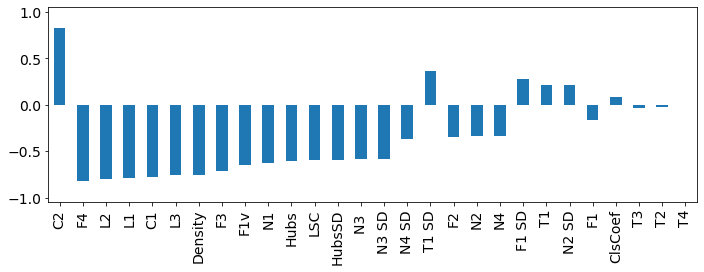

In [13]:
cols = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 
    'N2', 'N2 SD', 'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 
    'L1', 'L2', 'L3', 'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 
    'Hubs', 'HubsSD', 'rate']

df_c_measure = df_c_measure[cols]

cor = df_c_measure[cols].corr()
cor_rate = cor['rate']

plt.figure(figsize=figsize)
cor_rate[cor_rate.abs().sort_values(ascending=False).keys()[1:]].plot.bar()
plt.title('')
plt.ylim([-1.05, 1.05])
plt.tight_layout()
name = 'synth_cor_rate_falfa'
path_fig = os.path.join(path_output, f'{name}.pdf')
plt.savefig(path_fig, dpi=300)

path_output = os.path.join(PATH_ROOT, 'results', f'{name}.csv')
cor_rate.to_csv(path_output, index=True)